<a href="https://colab.research.google.com/github/faizanahemad/data-science-utils/blob/master/data_science_utils/vision/keras/Cutout_Gradcam_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook we provide few more examples of how my keras vision utils can help.

- Using Cutout and Seeing examples of what gets cut
- Using Cutout on our cifar10 net and seeing Gradcam activations
- Seeing Activations from VGG16 and detecting objects

I will only use cutout in this notebook. Model without cutout is not shown for comparison but is easy to make by changing the call to `train_network()`

[My Repo link](https://github.com/faizanahemad/data-science-utils)

**Give it a Star** if you found this useful

In [2]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null
 

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4upstkom


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

from keras.applications.xception import Xception, preprocess_input as ppix, decode_predictions


from keras.preprocessing import image
import numpy as np
import cv2

import gc

InteractiveShell.ast_node_interactivity = "all"

In [0]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()


def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

# Using Cutout and seeing what is getting cut

```python
preprocessing_function=get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)
```

- `p=0.5`: defines the probability that a image will have cutout.
- `max_erasures_per_image=2`: defines maximum possible cutouts in an image
- `pixel_level=True`: Means that the cutout portion is randomly colored instead of black. If set to False uses the min pixel of image to color the cutout

## Images with Cutout

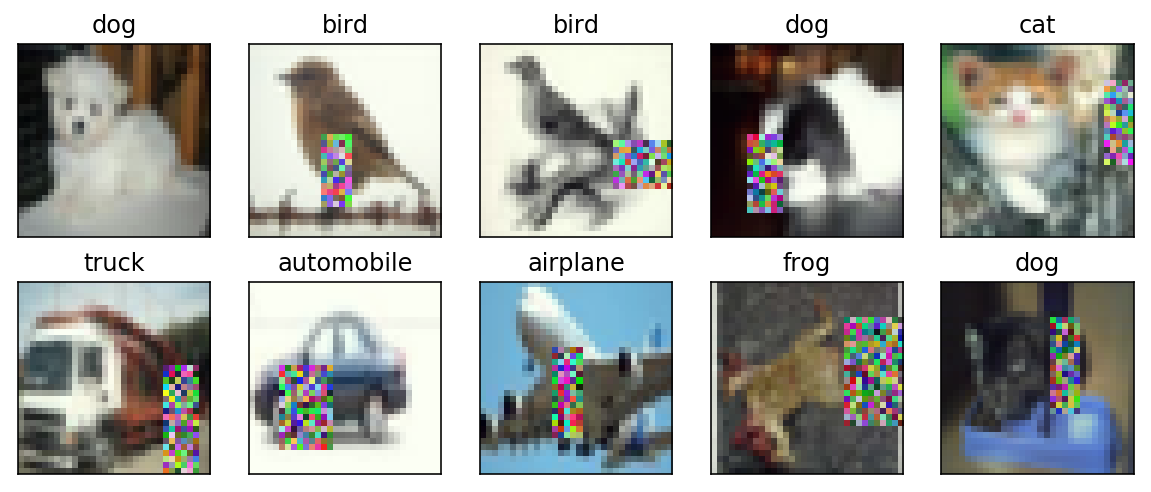

In [138]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, 
                                                                      max_erasures_per_image=1, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())


# try changing pixel_level=False

## Images without cutout

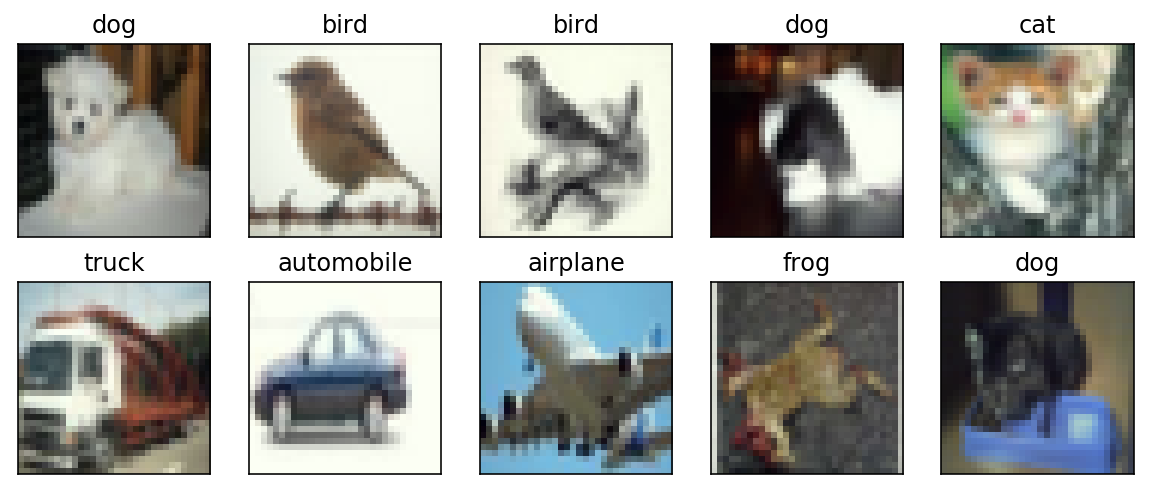

In [139]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=None)

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

# Cifar10 network

We use a few convinience functions:
- `conv_layer`: defines a conv layer with batchnorm, dropout and spatial dropout.
- `transition_layer`: defines 1x1 bottleneck layers easily
- `concat_s2d`: Concat outputs of 2 layers when their sizes are integer multiples of each other. Uses `tf.space_to_depth` inside

You can see the all code [here](https://github.com/faizanahemad/data-science-utils/blob/master/data_science_utils/vision/keras/layer_utils.py)

Code of conv layer is below. I just added common useful things we do here.

In [3]:
misc.print_code(conv_layer)

def conv_layer(inputs, name, n_kernels=32, kernel_size=(3, 3), dropout=0.0, dilation_rate=1, padding='same',
               enable_transition=False, transition_layer_kernels=32, strides=1, spatial_dropout=0.0,bn=True,
               bn_zero_gamma=False):
    inputs = concat_s2d(inputs)
    inputs = transition_layer(inputs, name + "_tran", transition_layer_kernels) if enable_transition else inputs
    out = Conv2D(n_kernels,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding=padding,
                 kernel_regularizer=l2(1e-4),
                 dilation_rate=dilation_rate,
                 name=name + "conv_")(inputs)
    if bn:
        out = BatchNormalization(name=name + "bn_", gamma_initializer='zeros')(
            out) if bn_zero_gamma else BatchNormalization(name=name + "bn_")(out)
    out = Activation("relu", name=name + "activation_")(out)
    out = Dropout(dropout, name=name + "dropout_")(out) if dropout > 0 else out
    out = 

Below we define a function that builds our model. We return our model from this buider function since we need to build our model 2 times, once without cutout and one with it.

In [0]:
def build_model():
  inputs = Input(shape=(32,32,3))
  x = conv_layer(inputs,name="c1",n_kernels=16, padding='valid')
  x = conv_layer(x,name="c2",n_kernels=32, padding='valid')
  x = conv_layer(x,name="c3",n_kernels=48, padding='same', spatial_dropout=0.1)
  x = conv_layer(x,name="c4",n_kernels=64, padding='same', spatial_dropout=0.2)
  x = MaxPooling2D()(x) # 16
  x = transition_layer(x,"tran_1", 32)
  x1 = x # skip conn 1
  
  
  x = conv_layer(x,name="c5",n_kernels=16, padding='same')
  x = conv_layer(x,name="c6",n_kernels=32, padding='same')
  x = conv_layer(x,name="c7",n_kernels=48, padding='same', spatial_dropout=0.1)
  x = conv_layer(x,name="c8",n_kernels=64, padding='same', spatial_dropout=0.2)
  x2 = x # skip conn 2
  
  x = MaxPooling2D()(x) # 8
  x = transition_layer(x,"tran_2", 32)
  
  print("Concat: Shape of 1st = %s, Shape of 2nd = %s"%(K.int_shape(x1),K.int_shape(x)))
  x = concat_s2d([x1,x])
  print("Shape after concat =",K.int_shape(x))
  print("="*80)
  x = conv_layer(x,name="c9",n_kernels=16, padding='same')
  x = conv_layer(x,name="c10",n_kernels=32, padding='same',spatial_dropout=0.1)
  x = conv_layer(x,name="c11",n_kernels=48, padding='same',spatial_dropout=0.2)
  
  print("Concat: Shape of 1st = %s, Shape of 2nd = %s"%(K.int_shape(x1),K.int_shape(x)))
  x = concat_s2d([x2,x])
  print("Shape after concat =",K.int_shape(x))
  print("="*80)
  
  out = transition_layer(x,"output_transition", 40,bn=False)
  out = Conv2D(10,
          kernel_size=1,
          strides=1)(out)
  out = GlobalAveragePooling2D()(out)
  out = Activation("softmax")(out)
  
  model = Model(inputs=inputs, outputs=out)
  optimizer = Adam(0.01)
  # optimizer = SGD(lr=0.02, decay=1e-3, momentum=0.9, nesterov=True)


  model.compile(loss='categorical_crossentropy',
               optimizer=optimizer,
               metrics=['accuracy'])
  print("Model Params = ",model.count_params())
  print("="*80)
  return model

In [69]:
model = build_model()

Concat: Shape of 1st = (None, 14, 14, 32), Shape of 2nd = (None, 7, 7, 32)
Shape after concat = (None, 7, 7, 160)
Concat: Shape of 1st = (None, 14, 14, 32), Shape of 2nd = (None, 7, 7, 48)
Shape after concat = (None, 7, 7, 304)
Model Params =  157778


In [0]:
def train_network(model,epochs=25,cutout=False):
  cutout_fn = get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)
  
  datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=cutout_fn if cutout else None)

  datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
  datagen.fit(X_train)
  datagen_validation.fit(X_train)
  train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
  validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)
  lr_manager = OneCycleLR(samples=X_train.shape[0], epochs=10, batch_size=256,
                        steps=len(train_iterator), max_lr=0.001,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)
  
  checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

  train_history = model.fit_generator(train_iterator,
                      steps_per_epoch=len(train_iterator), 
                      validation_data = validation_iterator, 
                      validation_steps = len(validation_iterator),
                      epochs=epochs, verbose=2,callbacks=[lr_manager,checkpoint])
  
  model.load_weights("model.hdf5")
  iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
  score = model.evaluate_generator(iterator,steps=len(iterator))
  iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
  predictions = model.predict_generator(iterator,steps=len(iterator))
  _ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


  iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
  score = model.evaluate_generator(iterator,steps=len(iterator))
  iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
  predictions = model.predict_generator(iterator,steps=len(iterator))
  _ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

  return train_history

In [77]:
train_history = train_network(model,epochs=25,cutout=True)

Epoch 1/25
 - 31s - loss: 0.6345 - acc: 0.8178 - val_loss: 0.5849 - val_acc: 0.8461
 - lr: 0.00030 
Epoch 2/25
 - 31s - loss: 0.6318 - acc: 0.8199 - val_loss: 0.6112 - val_acc: 0.8335
 - lr: 0.00050 
Epoch 3/25
 - 30s - loss: 0.6403 - acc: 0.8164 - val_loss: 0.6224 - val_acc: 0.8303
 - lr: 0.00070 
Epoch 4/25
 - 30s - loss: 0.6440 - acc: 0.8157 - val_loss: 0.6015 - val_acc: 0.8377
 - lr: 0.00090 
Epoch 5/25
 - 30s - loss: 0.6535 - acc: 0.8121 - val_loss: 0.6360 - val_acc: 0.8271
 - lr: 0.00090 
Epoch 6/25
 - 30s - loss: 0.6478 - acc: 0.8131 - val_loss: 0.6029 - val_acc: 0.8357
 - lr: 0.00070 
Epoch 7/25
 - 30s - loss: 0.6292 - acc: 0.8200 - val_loss: 0.5847 - val_acc: 0.8420
 - lr: 0.00050 
Epoch 8/25
 - 30s - loss: 0.6139 - acc: 0.8230 - val_loss: 0.5703 - val_acc: 0.8448
 - lr: 0.00030 
Epoch 9/25
 - 30s - loss: 0.5962 - acc: 0.8310 - val_loss: 0.5720 - val_acc: 0.8466
 - lr: 0.00010 
Epoch 10/25
 - 30s - loss: 0.5832 - acc: 0.8343 - val_loss: 0.5665 - val_acc: 0.8505
 - lr: 0.00000 

In [78]:
print([layer.name for layer in model.layers[0:] if "conv" in layer.name])

['c1conv_', 'c2conv_', 'c3conv_', 'c4conv_', 'c5conv_', 'c6conv_', 'c7conv_', 'c8conv_', 'c9conv_', 'c10conv_', 'c11conv_', 'conv2d_50']


# Visualizing GradCam with Cutout

In [0]:
def gradcam(model,layer,img,class_idx,preprocess_func=None,
            show=False):
  
  x = np.expand_dims(image.img_to_array(img), axis=0)
  img = np.copy(img)
  class_idx = np.argmax(class_idx, axis=0) if type(class_idx)==list or type(class_idx)==np.ndarray else class_idx
  if preprocess_func is not None:
    x = preprocess_func(x)
  preds = model.predict(x)
  preds = np.argmax(preds, axis=1)[0]
  
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
    
  heatmap = heatmap/255
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if heatmap[i][j][1]<=0.01 and heatmap[i][j][2]<=0.01:
        heatmap[i][j] = 0
        
  img = (img - np.min(img))/(np.max(img)-np.min(img))
  superimposed_img = 0.65*(img) + 0.35*heatmap
  
  for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
      if np.sum(heatmap[i][j])==0:
        superimposed_img[i][j]=img[i][j]
  
  if show:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.imshow(heatmap)
    plt.axis("off")
    plt.show()
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()
  return img,heatmap,superimposed_img,preds


def show_examples_with_gradcam(model,layer,images,labels,classes=None,preprocess_func=None,image_size_multiplier=3):
  columns = 5
  rows = int(np.ceil(len(images) / columns))
  labels = np.argmax(labels, axis=1) if type(labels[0])==list or type(labels[0])==np.ndarray else labels
  fig_height = rows * image_size_multiplier * 3
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(images):
      break
    x = images[i]
    y = labels[i]
    img,heatmap,superimposed_img,prediction = gradcam(model,layer,x,y,preprocess_func=preprocess_func,show=False)
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.15)
    imgs = [img,heatmap,superimposed_img]
    label = classes[y] if classes is not None else ""
    label = label.split(' ', 1)[0]
    prediction = classes[prediction]
    titles = [("Actual:"+label+" Pred:"+prediction).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[j])
        fig.add_subplot(ax)
  
  fig.show()
  

def show_layers_with_gradcam(model,layers,image,label,classes=None,preprocess_func=None,image_size_multiplier=3):
  columns = 5
  rows = int(np.ceil(len(layers) / columns))
  label = np.argmax(label, axis=0) if type(label)==list or type(label)==np.ndarray else label
  fig_height = rows * image_size_multiplier * 3
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(layers):
      break
    layer = layers[i]
    img,heatmap,superimposed_img,prediction = gradcam(model,layer,image,label,preprocess_func=preprocess_func,show=False)
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.15)
    imgs = [img,heatmap,superimposed_img]
    lbl = classes[label] if classes is not None else ""
    lbl = lbl.split(' ', 1)[0]
    prediction = classes[prediction]
    titles = [(layer+" Actual:"+lbl+" Pred:"+prediction).replace(' ', '\n'),"HeatMap","SuperImposed Image"]
    for j in range(3):
        
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[j])
        fig.add_subplot(ax)
  
  fig.show()

We have 2 APIs in for GradCam

- **`show_layers_with_gradcam`**: which takes 1 image and multiple layer names, and shows gradcam for 1 image in the multiple layers. 

```python
show_layers_with_gradcam(model,layers=["c11conv_","output_transition","conv2d_15"],image=X_e[13], label=Y_e[13],
                         classes=get_cifar10_labels())
```

- **`show_examples_with_gradcam`**: which takes multiple images and 1 layer name and shows gradcam for all the passed images for that layer.

```python
show_examples_with_gradcam(model,layer="c11conv_",images=X_e[10:30], labels=Y_e[10:30],
                           classes=get_cifar10_labels())
```

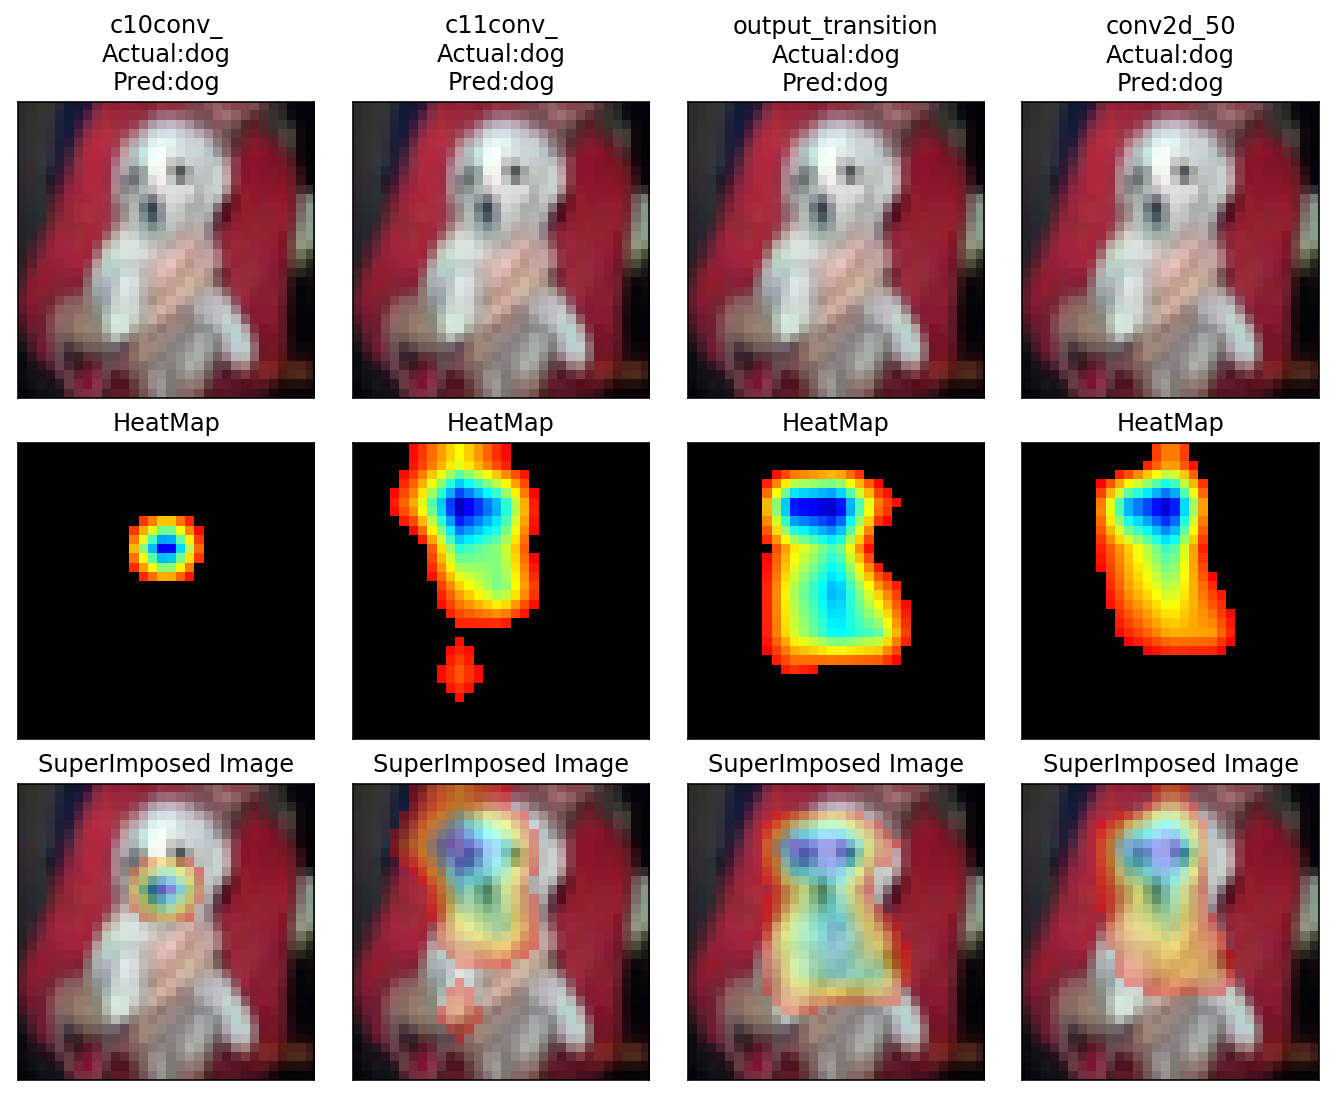

In [140]:
show_layers_with_gradcam(model,layers=["c10conv_","c11conv_","output_transition","conv2d_50"],image=X_e[12], label=Y_e[12],
                         classes=get_cifar10_labels())

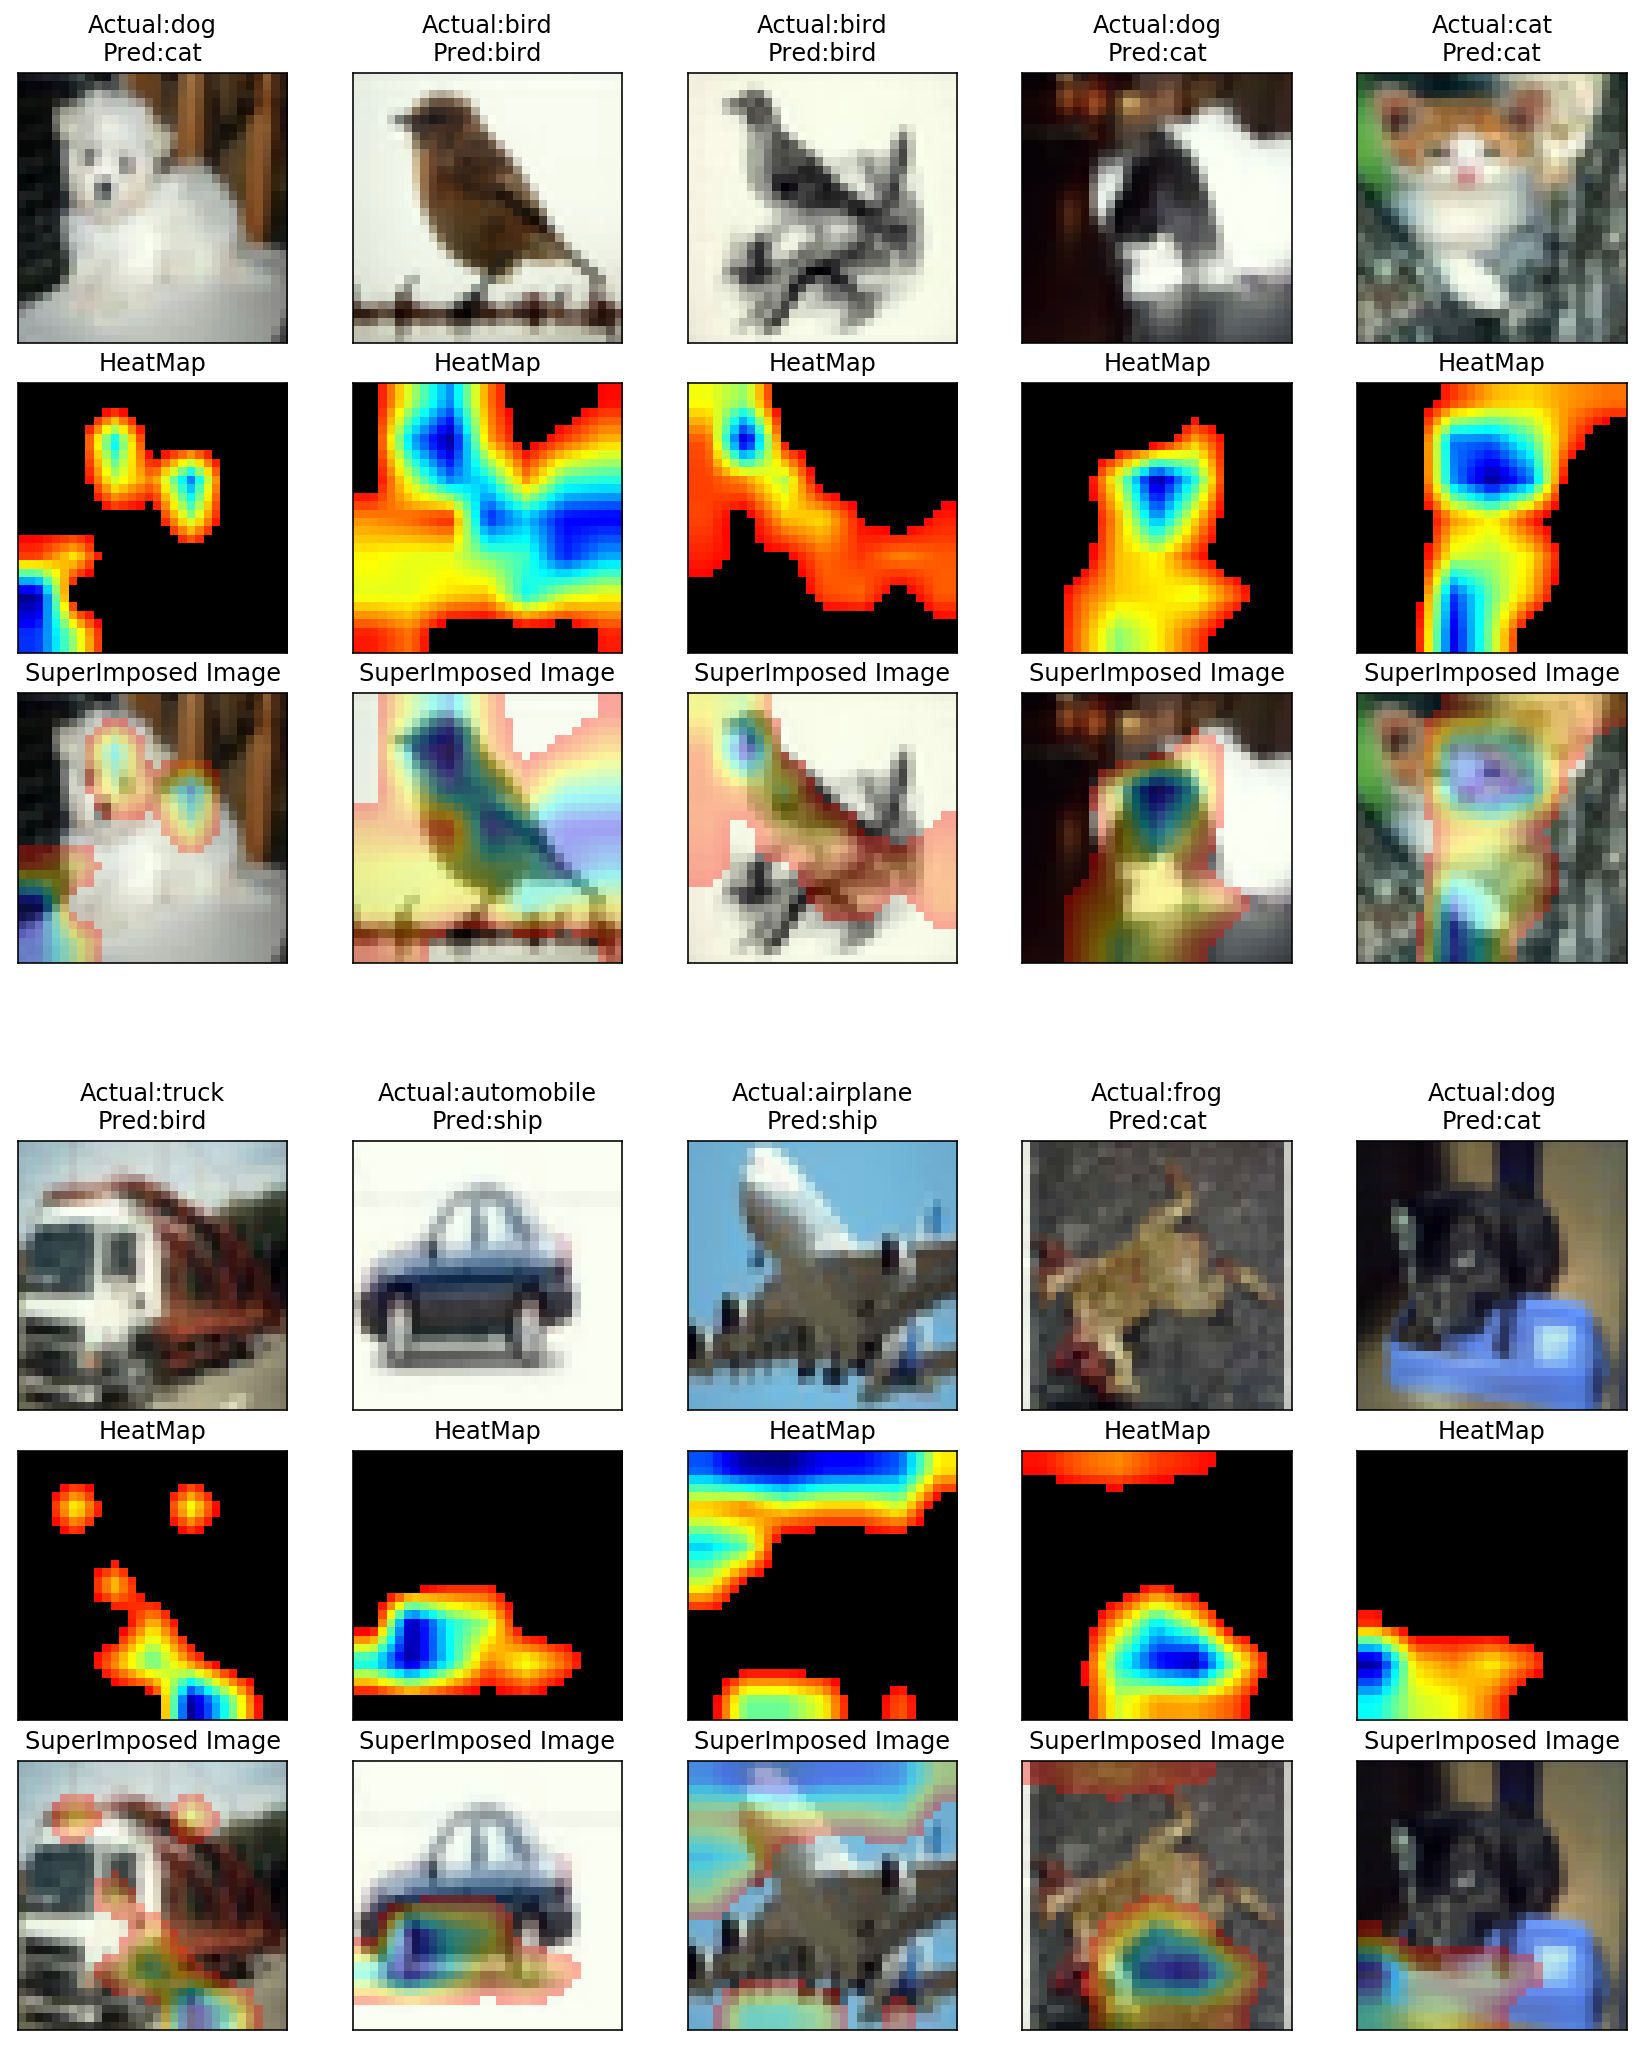

In [141]:

show_examples_with_gradcam(model,layer="conv2d_50",images=X_e[0:10], labels=Y_e[0:10],
                           classes=get_cifar10_labels())


Notice how when predictions are correct, gradcam falls in right place, but when predictions are wrong gradcam placement is also wrong.

# Visualizing PreTrained Model (VGG16)

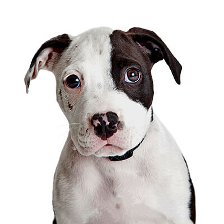

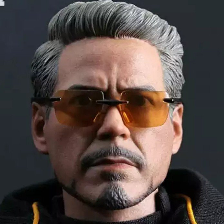

In [85]:
from skimage import io
vgg_model = VGG16(weights="imagenet")

dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))

rdj = io.imread("https://github.com/faizanahemad/eva/raw/master/assignment-10/rdj_glasses.jpg")
rdj = cv2.resize(rdj, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(rdj, cv2.COLOR_BGR2RGB))


## Same image different layers 

For getting imagenet classes as an array we use `get_imagenet_labels()`

Preprocessing function for images in defined above for vgg as `vgg_process_img`

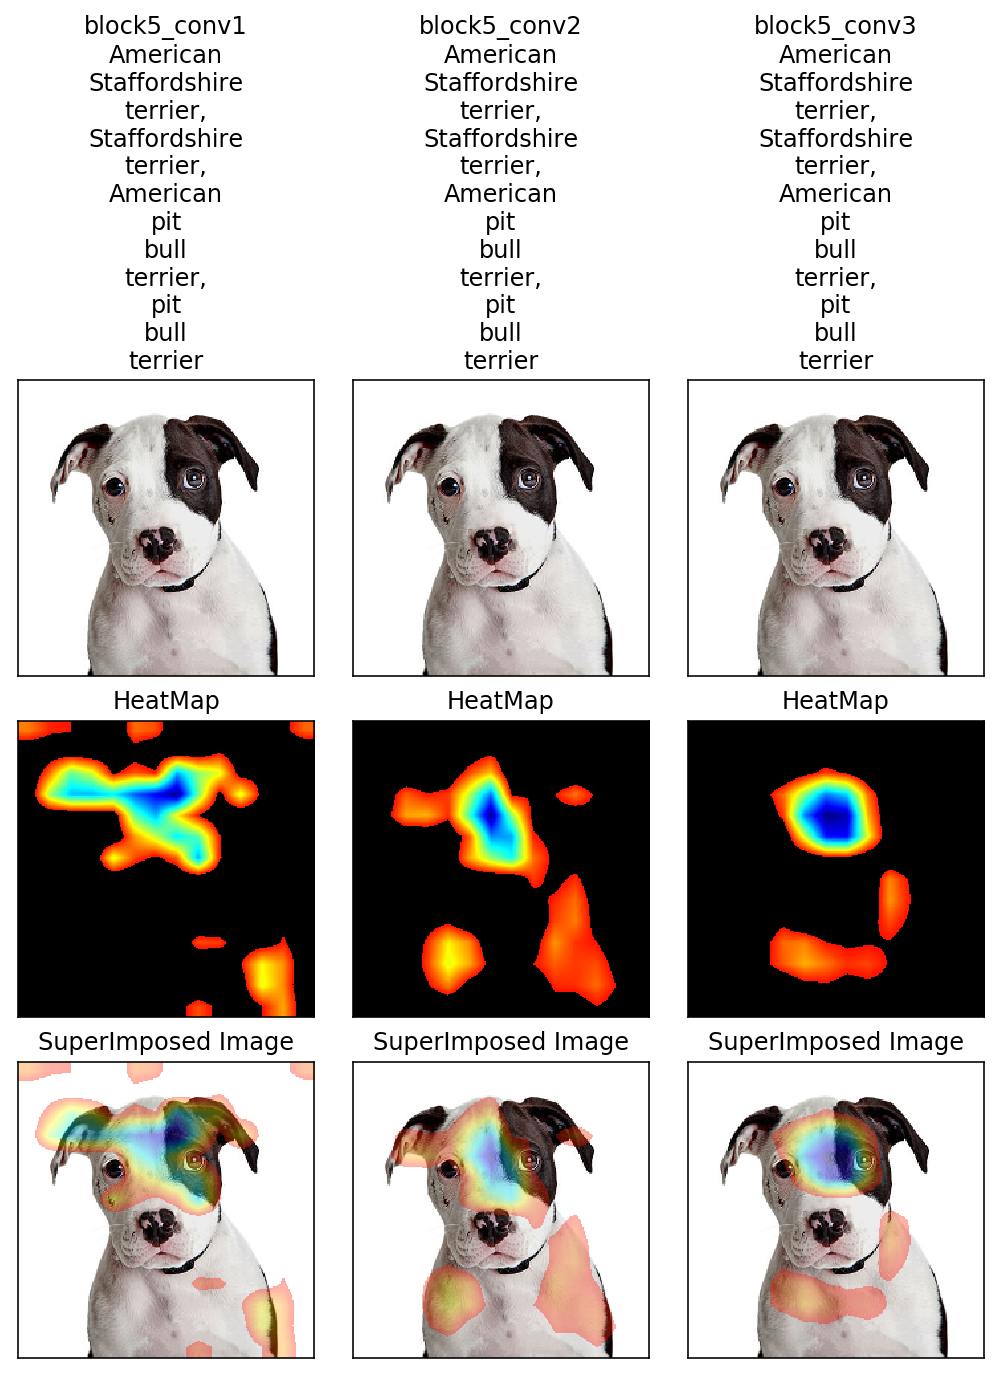

In [86]:
show_layers_with_gradcam(vgg_model,layers=['block5_conv1', 'block5_conv2', 'block5_conv3'],image=dog, label=180,
                         classes=get_imagenet_labels(),preprocess_func=keras.applications.vgg16.preprocess_input)

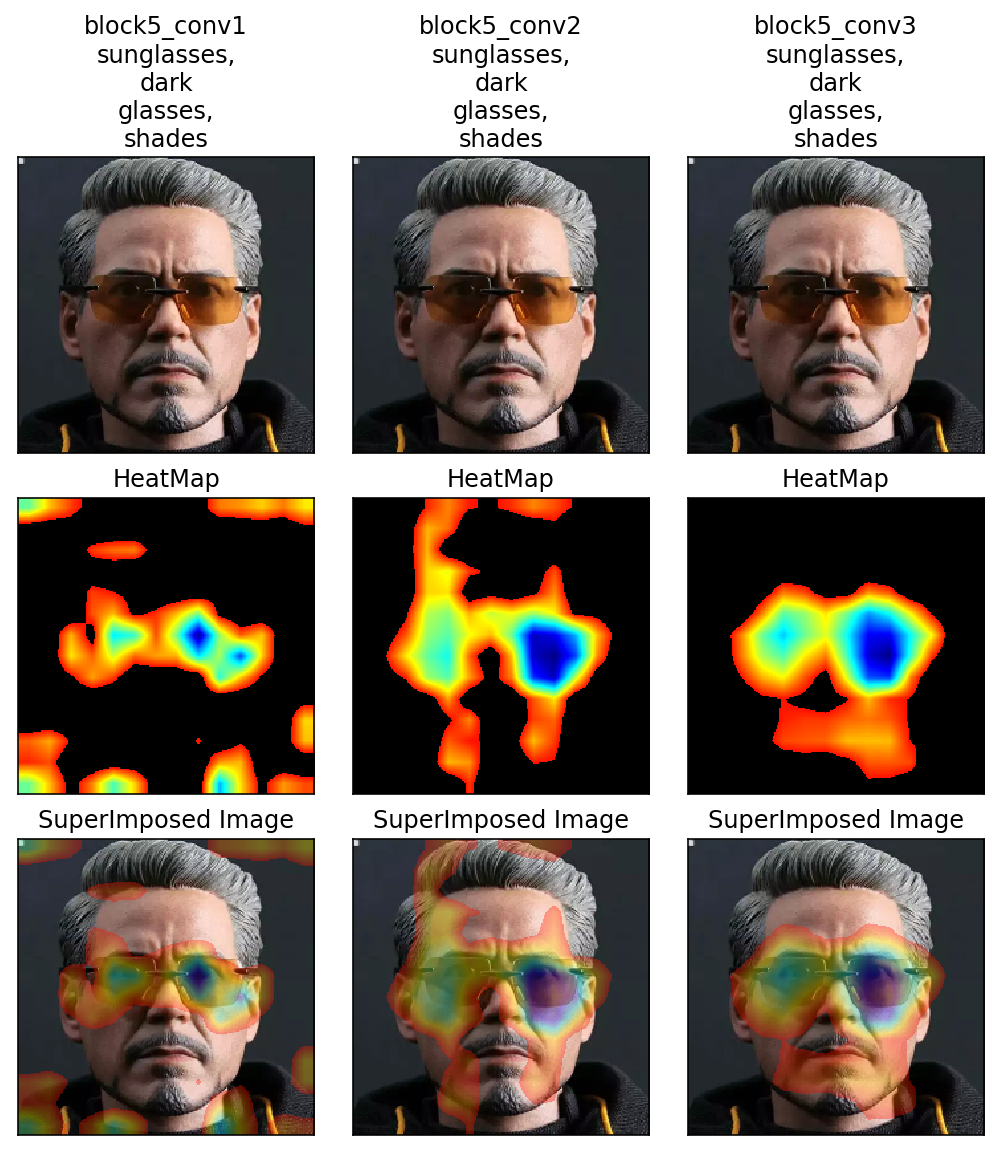

In [87]:
show_layers_with_gradcam(vgg_model,layers=['block5_conv1', 'block5_conv2', 'block5_conv3'],image=rdj, label=837,
                         classes=get_imagenet_labels(),preprocess_func=keras.applications.vgg16.preprocess_input)

## Different Images same layer

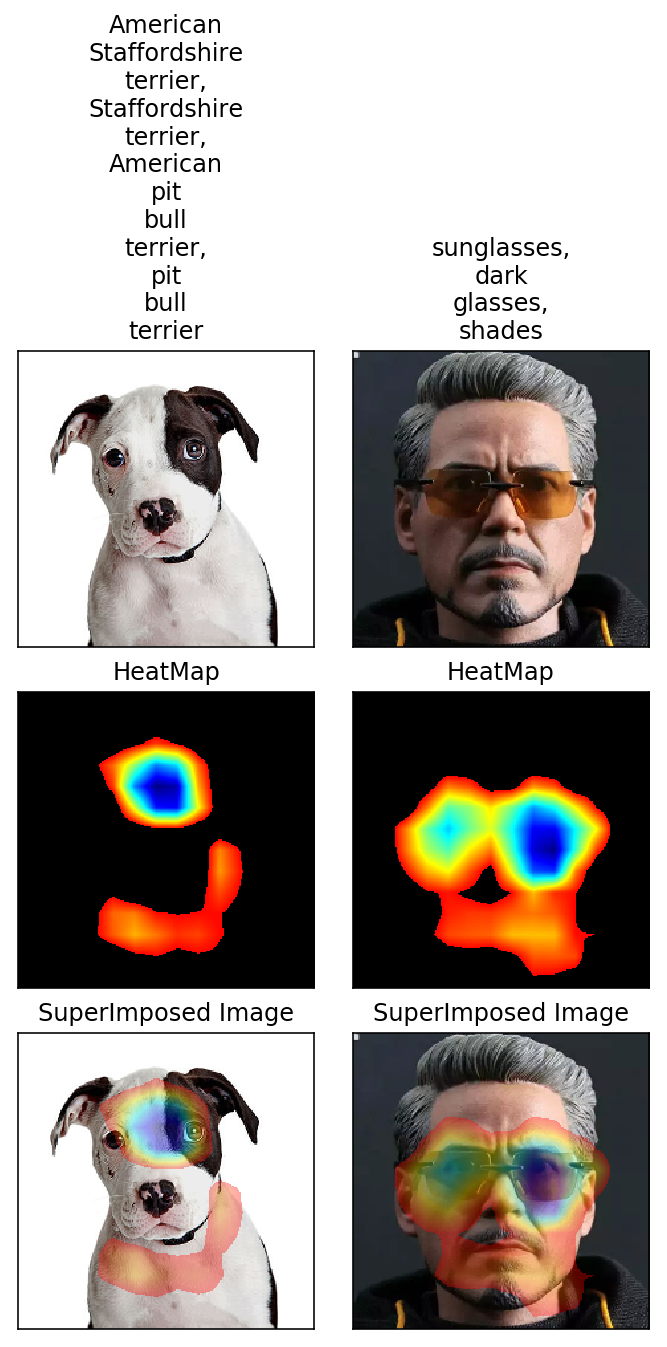

In [93]:
show_examples_with_gradcam(vgg_model,layer="block5_conv3",images=[dog,rdj], labels=[180,837],
                           classes=get_imagenet_labels(),preprocess_func=keras.applications.vgg16.preprocess_input)


# Using another network (XceptionNet)

In [0]:
xception = Xception(weights="imagenet")

dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)


rdj = io.imread("https://github.com/faizanahemad/eva/raw/master/assignment-10/rdj_glasses.jpg")
rdj = cv2.resize(rdj, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)



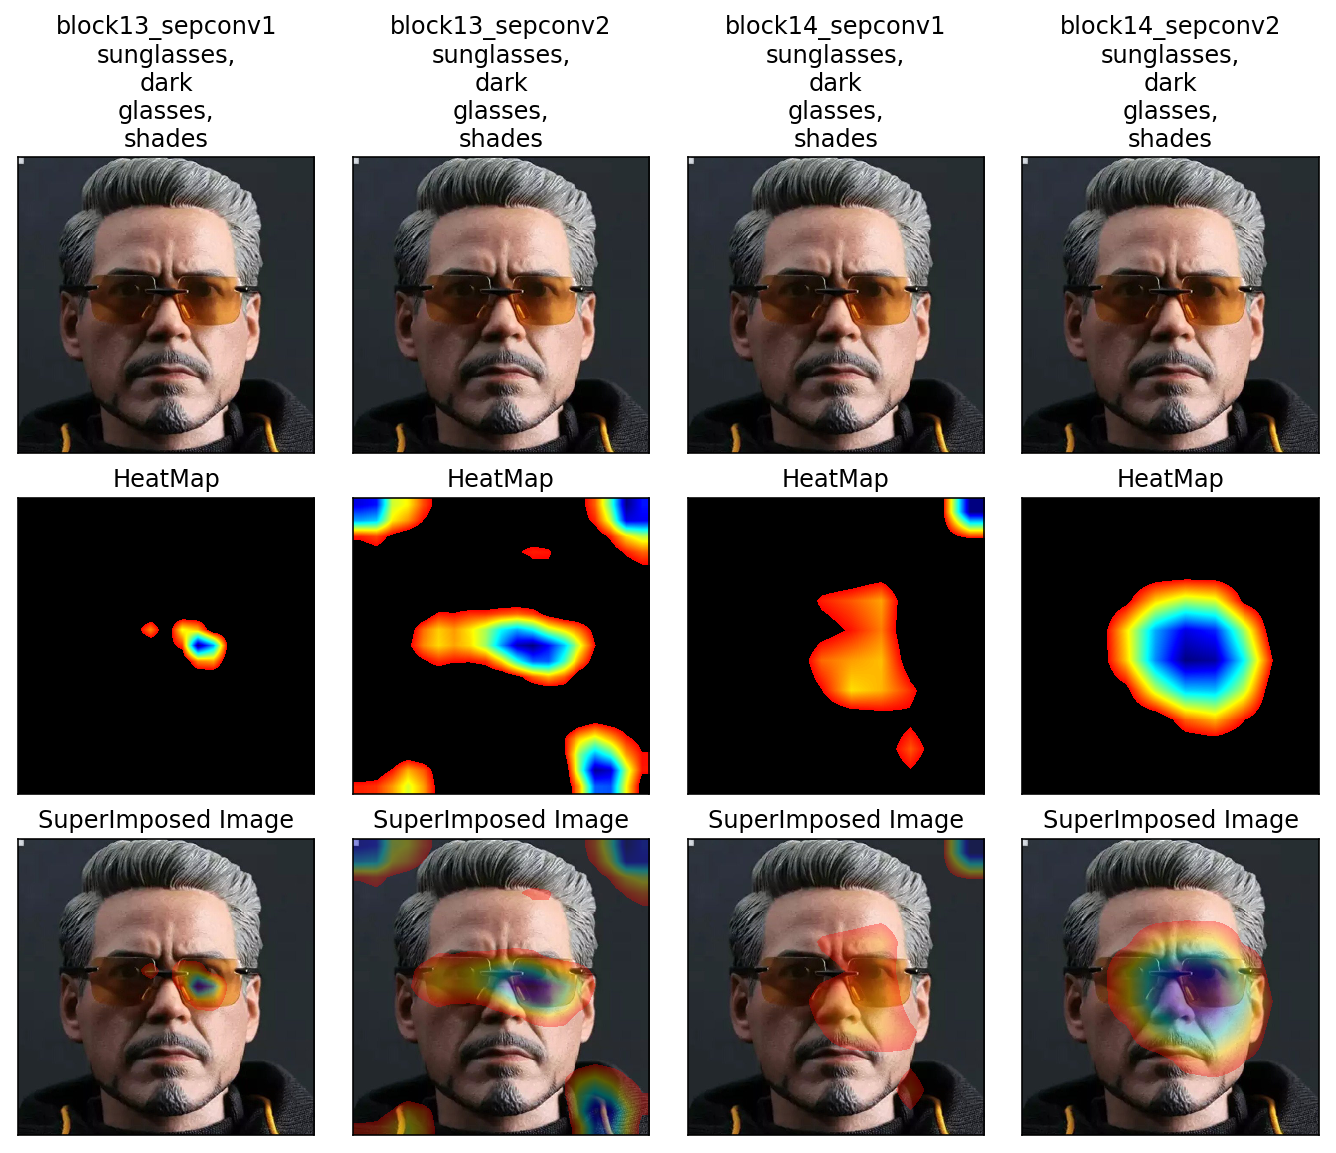

In [95]:
show_layers_with_gradcam(xception,layers=['block13_sepconv1','block13_sepconv2', 'block14_sepconv1', 'block14_sepconv2'],image=rdj, label=837,
                         classes=get_imagenet_labels(),preprocess_func=keras.applications.xception.preprocess_input)

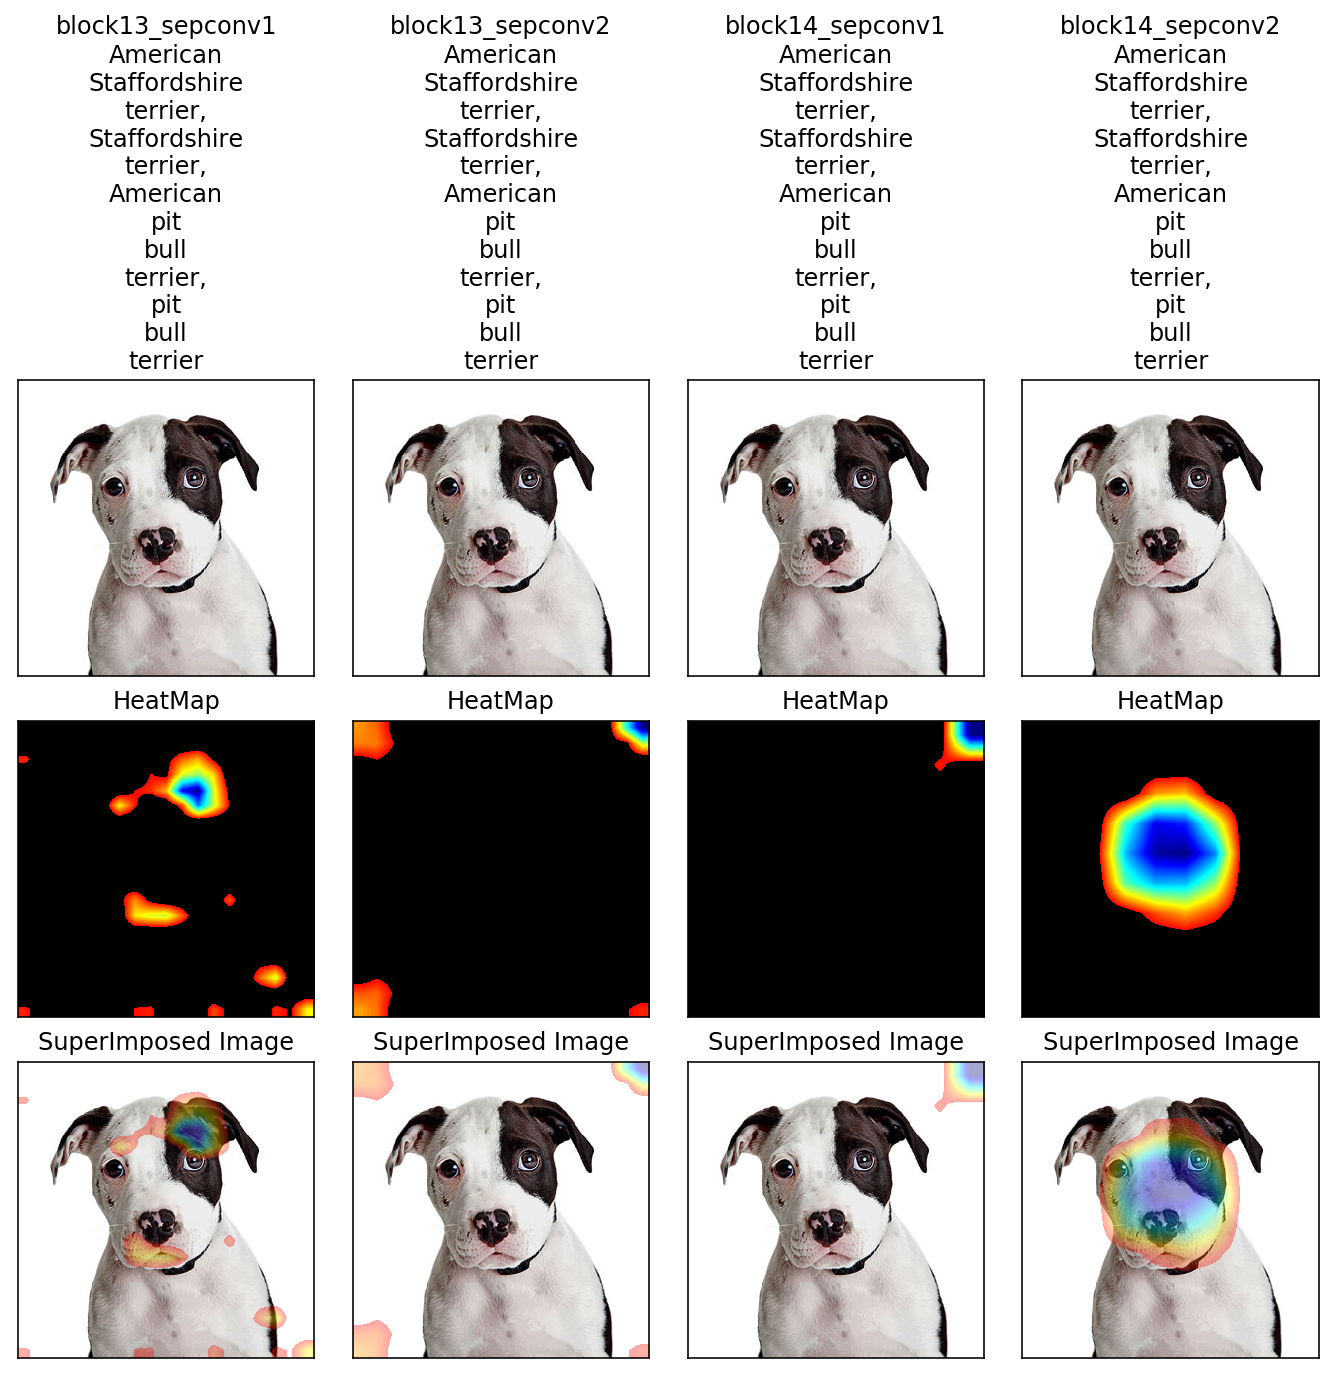

In [96]:
show_layers_with_gradcam(xception,layers=['block13_sepconv1','block13_sepconv2', 'block14_sepconv1', 'block14_sepconv2'],
                         image=dog, label=180,
                         classes=get_imagenet_labels(),preprocess_func=keras.applications.xception.preprocess_input)

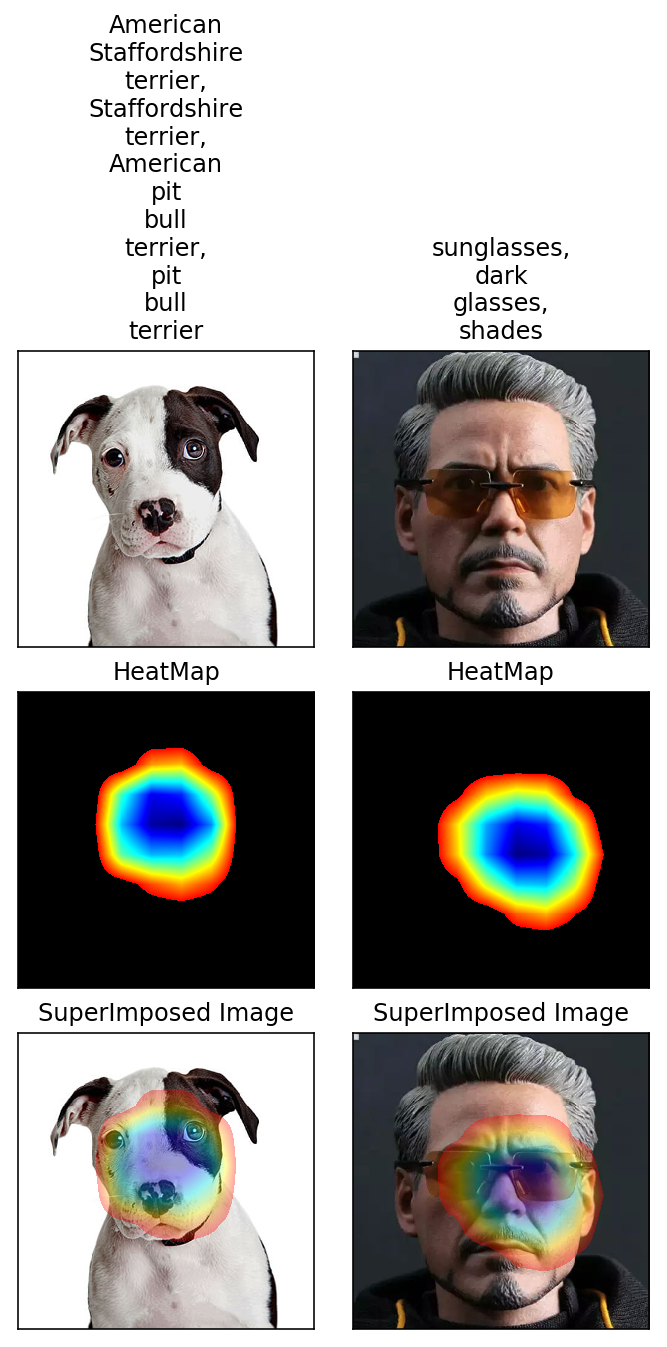

In [97]:
show_examples_with_gradcam(xception,layer="block14_sepconv2",images=[dog,rdj], labels=[180,837],
                           classes=get_imagenet_labels(),preprocess_func=keras.applications.xception.preprocess_input)
